# Energy Insecurity in the US: classification prediction


### Table of Contents
I. [Dependent vb selection](#background)<br>
II. [Data Cleaning](#load) <br>
III. [Classification: Forecasting and Prediction Modeling](#class) <br>
IV. [Import ACS & setup dataframe](#ACS)<br>
V. [Apply best regression model](#prediction_reg)<br>

#### Dependencies

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import warnings 
import geopandas as gpd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression



warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight') 

sns.set(style="ticks", rc={"axes.labelsize":36})

# Set some parameters
plt.rcParams['figure.figsize'] = (9, 7)
plt.rcParams['font.size'] = 9
np.set_printoptions(4)



import recs_EDA
#import regression_recs as reg # the split in test/train is found as a function here


%matplotlib inline  

In [15]:
import classification_recs_sample_weights as classif
import compare_classification_models as compare_class

#initilize model parameters
test_prop = 0.2
rand_seed = 5

## Dependent vb selection <a id='background'></a>

As an introduction to the prediction problems that we will perform, we will apply several methods for two types of prediction:
- Classification methods on `SCALEB`: whether a houshold has had to "forgo basic necessities due to home energy bills", and the frequency of such an event. We will aggregate this to a binary yes/no response to whether houholds forego basic needs due to energy bills.

##### Select Dependent Variable

In [52]:
# Select dependent variable
#y_name = 'SCALEB' #17% yes - reducing basing necessities due to energy bill
#y_name = 'SCALEG' #8.7% yes - keeping home at unhealthy temperatures
y_name = 'SCALEE' #8.9% yes - receiving disconnection notice
#maybe ENERGYASST



---

## Data Cleaning  <a id='load'></a>
We will walk through the data cleaning of RECS for out *preriction problem*. Merging processes do not occur in this section, since the merging of other datasets is done to prepare the ACS for the *resource allocation* problem, and is hence in the `ACS_EDA.ipynb`. Merging processes also occur for the final visualisations in this file.


##### 1. Import RECS


In [53]:
year_analysis = 2020
path = '/global/scratch/users/cristina_crespo/p1_data/'

RECS_raw = pd.read_csv(path + 'RECS/recs2020_public_v5.csv')
RECS_raw.shape

(18496, 789)

##### 2. Deal with nominal v ordinal variables, normalize & input missing data

In [54]:
X_sub, Y, RECS_norm_param = recs_EDA.vb_transform(RECS_raw) 

##### 3. Set up results table, set up y variable

In [55]:
#Set up summary dataframe to compare models
summary_table = pd.DataFrame(columns = ['Model', 'score']) 

y=Y[y_name].reset_index(drop = True) 

---

## Bootstrapping/feature engineering<a id='class'></a>


##### 1. Create splits for bootstraps

The following cell will be used for all regression models to create the cross validated test/train splits in the data (conserving the same random state and proportion throughout the model comparisons).

In [56]:
#divide test/train
test_prop = 0.2

#set up dep and indep vbs
#X = RECS_raw[['HDD30YR_PUB','CDD30YR_PUB','TYPEHUQ','KOWNRENT','YEARMADERANGE','BEDROOMS', 'NWEIGHT']]
#y = RECS_raw.TOTALBTU

boots = False
if boots == True:
    #save bootstrap proportions
    boot_samples = pd.DataFrame(columns=['boot_num', 'len_Xtrain','prop_18k', 'prop_126M'])
    
    #drop weights
    #drop weight column
    weights = X_sub.NWEIGHT
    X =  X_sub.drop('NWEIGHT', axis = 1)
                   
    #split with bootstraps
    n = round(math.sqrt(len(X)))
    for b in range(n):
        
        X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(X,y, weights, test_size =test_prop, random_state=b)

        boot_samples.loc[b, 'boot_num'] = b
        boot_samples.loc[b, 'len_Xtrain'] = len(X_train)
        boot_samples.loc[b, 'prop_18k'] = len(X_train)/len(X_sub)
        boot_samples.loc[b, 'prop_126M'] = X_train.NWEIGHT.sum()/X_sub.NWEIGHT.sum()
        #drop weight column
        X = X_sub.drop(columns = ['NWEIGHT'], inplace = True)
else:
    b = 0
    #drop weight column
    weights = X_sub.NWEIGHT
    X = X_sub.drop('NWEIGHT', axis = 1)
    X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(X,y, weights, test_size =test_prop, random_state=b)


apply_weights = True
if apply_weights == True:
    pass
else:
    sw_train = np.ones(len(sw_train))
    sw_test = np.ones(len(sw_test))
         
    

In [57]:
#Oversampling and undersampling for the Sub model in order to reduce imbalanced dataset
print(y_train.value_counts())

os_type = 'none' #smote, under, over, none --> TO DO CANNOT UNCERSAMPLE WITH SAMPLE WEIGHTS?
X_train, y_train = classif.resample(X_train, y_train, os_type)

print(y_train.value_counts())

SCALEE
0    13446
1     1350
Name: count, dtype: int64
SCALEE
0    13446
1     1350
Name: count, dtype: int64


In [58]:
len(X_train)

14796

##### 2. Feature engineering


In [59]:
#Feature Engineering 
feature_engineer = False

n = len(X.columns)

if feature_engineer == True:
    interactions = 1+0.5*n+0.5*n**2 - 1 #intercept
    
    poly = PolynomialFeatures(interaction_only=True,include_bias = False)
    X_train_eng = poly.fit_transform(X_train)
    X_test_eng = poly.fit_transform(X_test)
    
    X_train = pd.DataFrame(X_train_eng, columns = poly.get_feature_names(X_train.columns))
    X_test = pd.DataFrame(X_test_eng, columns = poly.get_feature_names(X_test.columns))
else:
    interactions = n

---

## Classification: Apply best model <a id='prediction_class'></a>

Results AUC of the ROC:
- SCALEB
GB 0.80
log 0.80

- SCALEE
log 0.79

- SCALEG
GB 0.72
log 0.72

In [60]:
df_acs_raw = pd.read_csv(path+'out_final/ct_enhanced_model_application_final.csv')
#this file is generated by 2_prep_us_ct_variables.ipynb
df_acs = df_acs_raw.drop(columns = ['Unnamed: 0', 'total_population', 'state', 'county', 'tract'])

In [61]:
len(df_acs)

82907

In [62]:
#fill in missing value
df_acs.loc[df_acs['Average year built'].isna(), 'Average year built'] = df_acs['Average year built'].median()

In [63]:
df_acs.isna().sum().sum()

0

In [64]:
def align_features(df_acs, X_train):
    """
    Aligns df_acs to have the same column names, order, and data types as X_train.
    
    Parameters:
    df_acs (pd.DataFrame): The new data to apply the model to.
    X_train (pd.DataFrame): The training data used to fit the model.
    
    Returns:
    pd.DataFrame: Aligned df_acs with column names, order, and dtypes matching X_train.
    """

    # Rename and reorder columns to match X_train
    df_acs.columns = X_train.columns
    df_acs = df_acs[X_train.columns]

    # Convert data types to match
    for col in X_train.columns:
        expected_dtype = X_train[col].dtype
        actual_dtype = df_acs[col].dtype
        if expected_dtype != actual_dtype:
            df_acs[col] = df_acs[col].astype(expected_dtype)

    # Final assertions to confirm match
    assert list(df_acs.columns) == list(X_train.columns), "Column names do not match"
    assert all(df_acs.dtypes == X_train.dtypes), "Column types do not match"

    return df_acs

In [65]:
df_acs = align_features(df_acs, X_train)

In [66]:
#Apply threshhold used in training 
thresh = 0.7

if y_name == 'SCALEG': #Frequency of reducing or forgoing basic necessities due to home energy bill

    print('SCALEG')
    pred_name = "SCALEG_pred_th=0.7"
    odds_name = "SCALEG_odds"

    #gen model
    logreg, summary_table, y_pred_logistic = classif.logistic_fit(X_train, y_train, X_test, y_test, sw_train, sw_test, summary_table, thresh)
    #apply model
    y_pred = logreg.predict(df_acs) 
    y_odd = logreg.predict_proba(df_acs)
    
    #apply threshold
    if thresh != 0.5:
        y_predict_prob_class_1 = y_odd[:,1]
        y_pred = [1 if p >= thresh else 0 for p in y_predict_prob_class_1]

    #save outputs
    df_acs[odds_name]=y_odd[:,1] 
    df_acs[pred_name]=y_pred
    
elif y_name == 'SCALEB':  #Frequency of keeping home at unhealthy temperature
    print('SCALEB')
    pred_name = "SCALEB_pred_th=0.7"
    odds_name = "SCALEB_odds"
    
    #gen model
    logreg, summary_table, y_pred_logistic = classif.logistic_fit(X_train, y_train, X_test, y_test, sw_train, sw_test, summary_table, thresh)
    #apply model
    y_pred = logreg.predict(df_acs) 
    y_odd = logreg.predict_proba(df_acs)
    
    #apply threshold
    if thresh != 0.5:
        y_predict_prob_class_1 = y_odd[:,1]
        y_pred = [1 if p >= thresh else 0 for p in y_predict_prob_class_1]

    #save outputs
    df_acs[odds_name]=y_odd[:,1] 
    df_acs[pred_name]=y_pred
    
elif y_name == 'SCALEE': #Frequency of receiving disconnect notice
    print('SCALEE')
    pred_name = "SCALEE_pred_th=0.7"
    odds_name = "SCALEE_odds"
    
    #gen model
    logreg, summary_table, y_pred_logistic = classif.logistic_fit(X_train, y_train, X_test, y_test, sw_train, sw_test, summary_table, thresh)
    #apply model
    y_pred = logreg.predict(df_acs) 
    y_odd = logreg.predict_proba(df_acs)
    
    #apply threshold
    if thresh != 0.5:
        y_predict_prob_class_1 = y_odd[:,1]
        y_pred = [1 if p >= thresh else 0 for p in y_predict_prob_class_1]
    
    #save outputs
    df_acs[odds_name]=y_odd[:,1] 
    df_acs[pred_name]=y_pred
    
else:
    pass


SCALEE
Logistic Regression Performance:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91 22845003.658389173
           1       0.25      0.49      0.33 2028675.9850189607

    accuracy                           0.84 24873679.643408135
   macro avg       0.60      0.68      0.62 24873679.643408135
weighted avg       0.89      0.84      0.86 24873679.643408135

[[19826267.5425  3018736.1159]
 [ 1030183.2352   998492.7498]]


In [67]:
len(df_acs)

82907

### Save csv

In [68]:
df_acs_final = df_acs.join(df_acs_raw[['state', 'county', 'tract']], how='inner') 
df_acs_final[['state', 'county', 'tract', odds_name, pred_name]].to_csv(path+'out_final/metric_predictions/'+y_name+'_predict_ct.csv')  

In [69]:
len(df_acs_final)

82907

(array([  423.,  2899.,  9883., 12978., 17005., 16822., 13098.,  7325.,
         2304.,   170.]),
 array([0.0485, 0.1301, 0.2117, 0.2932, 0.3748, 0.4564, 0.538 , 0.6195,
        0.7011, 0.7827, 0.8642]),
 <BarContainer object of 10 artists>)

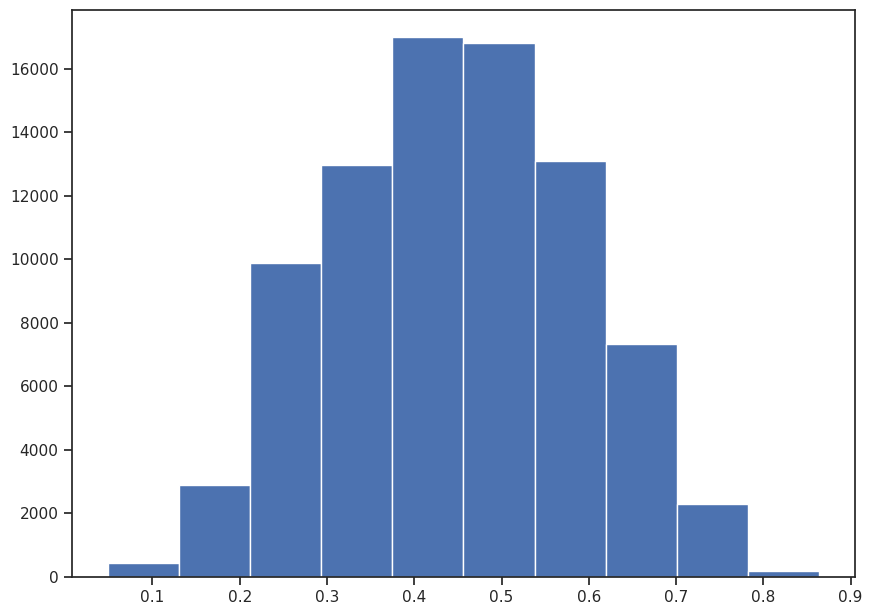

In [51]:
plt.hist(y_odd[:,1])